In [2]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors

## Lens Geometry

Central problem being parabolic, side being triangular.

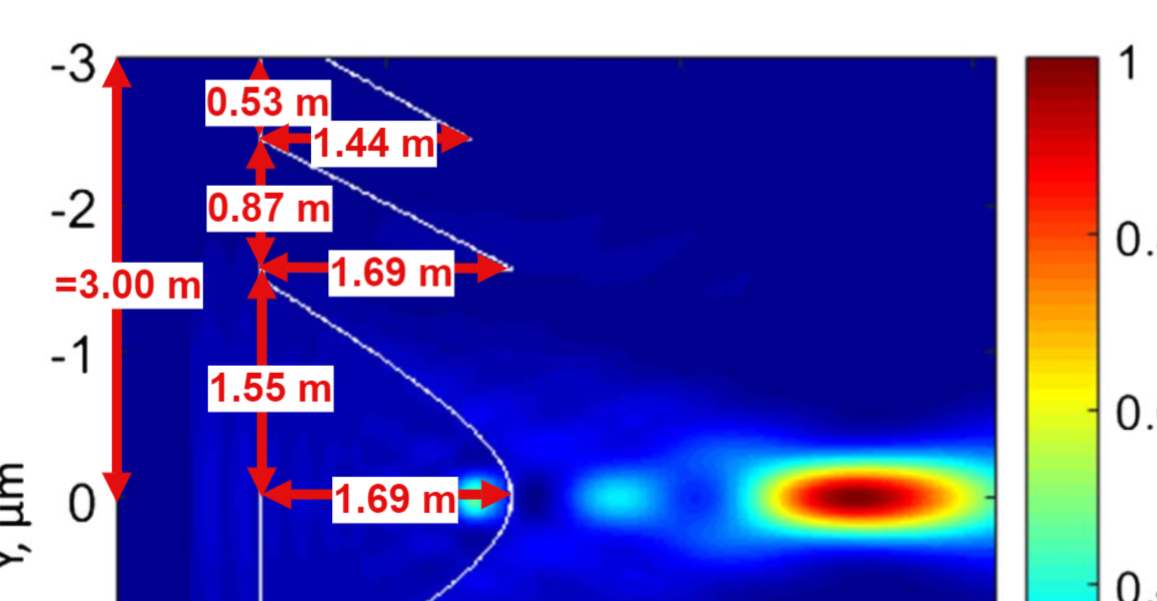

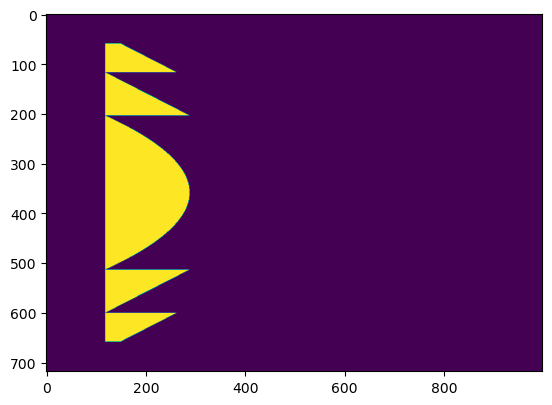

In [3]:
def Lor_mask(nx,nz,nx_pml,nz_pml,sample_inc):

    if sample_inc:
        nx -=2
        nz -=2
        return np.zeros((nx,nz)).astype(bool),np.ones((nx,nz)).astype(bool)

    xs,zs = np.indices((nx,nz))
    nx_offset = nx_pml + 100- 1/2
    nz_half = (nz/2-1/2)
    xs_norm = xs-(nx_offset)
    zs_norm = zs-(nz_half)

    def _parabola(half_length=1.55,height =1.7):
        half_length *= 100
        height *= 100
        #central parabola

        b1 = (xs_norm<= (-height/half_length**2 *(zs_norm)**2 + height))
        b2 = (xs_norm >= 0)

        return b1 & b2

    def _1stordertri(length=0.87,height =1.7,z_loc=1.55):
        length *= 100
        height *= 100
        z_loc *= 100
        #central parabola

        b1 = (np.abs(zs_norm) >=z_loc)
        b2 = (xs_norm >= 0)
        b3 = (np.abs(zs_norm) <= -length/height*(xs_norm)+z_loc+length)

        return b1 & b2 & b3


    def _2ndordertri(angle=0.87/1.7,height =1.44,z_loc=1.55+0.87, z_loc2=3):
        height *= 100
        z_loc *= 100
        z_loc2 *= 100
        #central parabola

        b1 = (np.abs(zs_norm) >=z_loc)
        b4 = (np.abs(zs_norm) <=z_loc2)

        b2 = (xs_norm >= 0)
        b3 = (np.abs(zs_norm) <= -angle*(xs_norm)+z_loc + angle*height)

        return b1 & b2 & b3 & b4
    
    lor_mask = _parabola(half_length=1.55,height =1.7) | \
           _1stordertri(length=0.87,height =1.7,z_loc=1.55) | \
           _2ndordertri(angle=0.87/1.7,height =1.44,z_loc=1.55+0.87, z_loc2=3) 
    not_lor_mask = np.logical_not(lor_mask)

    is_lor_E = lor_mask[1:-1,1:-1]
    is_notlor_E = not_lor_mask[1:-1,1:-1]
    return is_lor_E,is_notlor_E

mask1= Lor_mask(nx_pml = 20,nz_pml = 30,
                nx = 1000,nz = 720, sample_inc=0)[0].astype(int).T
plt.imshow(mask1)
plt.show()

## Update equation (TM)

$$\frac{\partial D_y}{\partial t} = [\frac{\partial H_x}{\partial z}- \frac{\partial H_z}{\partial x}]$$
$$\frac{\partial H_x}{\partial t} = -(1/\mu) [\frac{\partial E_y}{\partial z}]$$
$$\frac{\partial H_z}{\partial t} = (1/\mu) [\frac{\partial E_y}{\partial x}]$$

In [4]:
nxi=20
nzi=30
nx_pml = 4
nz_pml = 5

nx=nxi - 2
nz=nzi - 2
xs,zs = np.indices((nx,nz))

xs = xs - nx/2 + 1/2
zs = zs - nz/2 + 1/2

dist_x = nx/2 - 1/2 - nx_pml
dist_z = nz/2 - 1/2 - nz_pml

xs = np.maximum(abs(xs)-dist_x,0)
zs = np.maximum(abs(zs)-dist_z,0)
xs = xs/(np.max(xs)-np.min(xs))
zs = zs/(np.max(zs)-np.min(zs))

xzs = np.maximum(xs,zs)


pml_maskez = 10*((xzs)**2)
pml_maskex = 10*((xzs)**2)

# PML layer

In [5]:
def FDTD_PML(f0,sigma_ex_max,sigma_ez_max,sigma_mx_max,sigma_mz_max, steps= 1000, nx=200,nz=200):

    light_speed =  2.99792458e8        # % speed of light in free space
    n_out = 1.51                        #ref index outside material
    mu_0  = 4.0*np.pi*1.0e-7              # % free space magnetic permeability
    eps_0 = 1.0/((light_speed**2)*mu_0) # % free space dielectric permittivity
    eps_space = 1.51**2 *eps_0 # % immersion liquid dielectric permittivity

    # Mesh Definition
    dx = 10e-9
    dz = 10e-9 
    cfl = 0.9
# 
    dt = cfl*dz/(light_speed/n_out)/np.sqrt(2) # corresponds to 0.9 of the CFL limit

    # Location of excitation points 
    exc_pts_x = np.array([nx/2,nx/2,nx/2+1,nx/2+1]).astype(int)
    exc_pts_z = np.array([nz/2,nz/2+1,nz/2,nz/2+1]).astype(int)
# 
    # Source excitation function
    Ts = 100e-15 # 100 fs, ~30 μm, min pulse duration is ~12 fs, TODO
    nmax_exc = round(6*Ts/dt) #  % max number of time steps for excitation, TODO

    def _excitation_fx(dt):
        # Modulated Gaussian excitation
        t0 = 3*Ts 
        return np.sin(2*np.pi*f0*dt)*np.ones(len(exc_pts_x))
        # return np.exp(-(2*(dt-t0)/Ts)**2)*np.sin(2*np.pi*f0)*np.ones(len(exc_pts_x))


    # PML layer parameters:
    nx_pml = 30
    nz_pml = 30

    # Multipliers for perfect matched layer
    eps_pml = eps_space
    mu_pml = mu_0

    def _pml_sigma_grad_fx(mu_eps,sig_max,nx,nz):
        xs,zs = np.indices((nx,nz))

        xs = xs - nx/2 + 1/2
        zs = zs - nz/2 + 1/2

        dist_x = nx/2 - 1/2 - nx_pml
        dist_z = nz/2 - 1/2 - nz_pml

        xs = np.maximum(abs(xs)-dist_x,0)
        zs = np.maximum(abs(zs)-dist_z,0)
        xs = xs/(np.max(xs)-np.min(xs))
        zs = zs/(np.max(zs)-np.min(zs))
        xzs = np.maximum(xs,zs)

        sig = mu_eps*sig_max*((xzs)**2)
        return sig
    
    pml_sigex = _pml_sigma_grad_fx(eps_pml,sigma_ex_max,nx-2,nz-2)
    pml_sigez  = _pml_sigma_grad_fx(eps_pml,sigma_ez_max,nx-2,nz-2)
    pml_sigmx = _pml_sigma_grad_fx(mu_pml,sigma_mx_max,nx-1,nz)
    pml_sigmz = _pml_sigma_grad_fx(mu_pml,sigma_mz_max,nx,nz-1)
    
    # % === TIME STEPPING LOOP ===

    #storage
    Ey = np.zeros((steps,nx,nz))
    Eyx, Eyz = np.copy(Ey),np.copy(Ey)
    Hx, Hz = np.zeros((steps,nx,nz-1)), np.zeros((steps,nx-1,nz))
    
    for n in range(steps):    
        
        # E FIELD UPDATE (Normal + PML)
        Eyx[n,1:-1,1:-1] = (eps_pml/dt + pml_sigex/2)**(-1)*(
                            (eps_pml/dt - pml_sigex/2)*Eyx[n-1,1:-1,1:-1] 
                            +1/dx*(Hz[n-1,1:,1:-1]-Hz[n-1,:-1,1:-1]))

        Eyz[n,1:-1,1:-1] = (eps_pml/dt + pml_sigez/2)**(-1)*(
                    (eps_pml/dt - pml_sigez/2)*Eyz[n-1,1:-1,1:-1] 
                    -1/dz*(Hx[n-1,1:-1,1:]-Hx[n-1,1:-1,:-1]))
        # Update Total E FIELD
        Ey[n] = Eyx[n] + Eyz[n]
        # E-field Excitation
        if n < nmax_exc:
            tn = n*dt
            Ey[n,exc_pts_x,exc_pts_z] = _excitation_fx(tn)


        # H FIELD UPDATE (Normal + PML)
        Hz[n] = (mu_pml/dt + pml_sigmx/2)**(-1)*( 
                    (mu_pml/dt - pml_sigmx/2)*Hz[n-1] + 1/dx*(Ey[n,1:,]-Ey[n,:-1,:] ))
        
        Hx[n] = (mu_pml/dt + pml_sigmz/2)**(-1)*( 
                    (mu_pml/dt - pml_sigmz/2)*Hx[n-1] - 1/dz*(Ey[n,:,1:]-Ey[n,:,:-1] ))

    return Ey, Hx, Hz, dt

In [6]:
Ey1, Hx, Hz, dt = FDTD_PML(f0=3e17/550,sigma_ex_max=10e17,sigma_ez_max=10e17,sigma_mx_max=10e17,sigma_mz_max=10e17, steps= 250, nx=200,nz=200)

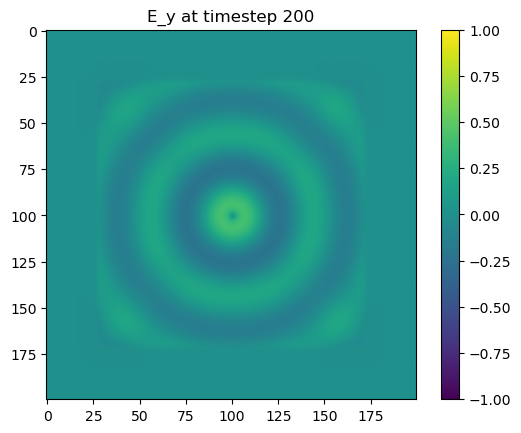

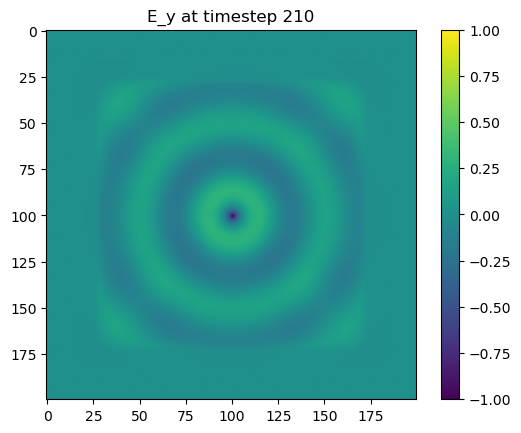

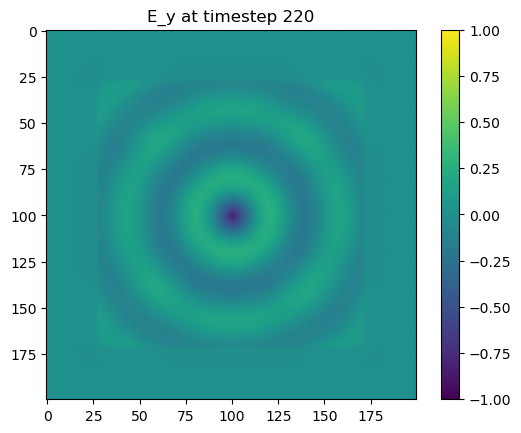

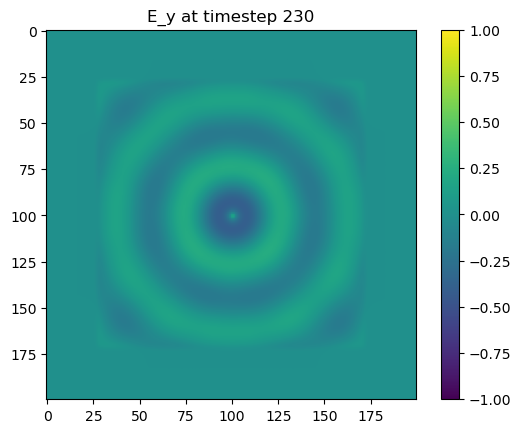

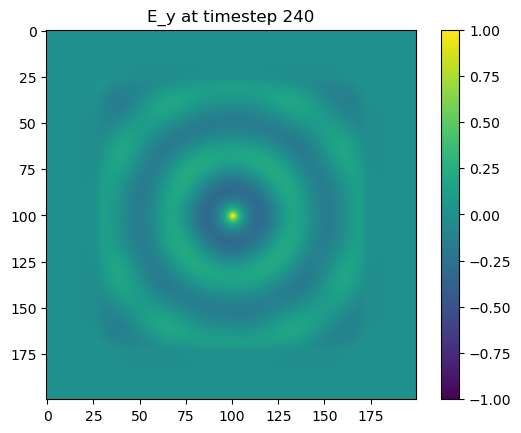

In [7]:
norm = plt.Normalize(-1, 1)
for i in range(200,250,10):
    plt.imshow(Ey1[i],norm=norm)
    plt.title("E_y at timestep {}".format(i))
    plt.colorbar()
    plt.show()

# ADE for Lorentizian material

Define Displacement field at a particular axis $D$ (axis subscript omitted): 

$$E=(1/\epsilon)D$$

For outside region, $\epsilon = n_{out}^2\epsilon_0$, for region inside Fresnel lens:

$$D(\omega) = \epsilon_0(1 + \frac{\omega^2_p}{\omega^2_0+j\omega\gamma -\omega^2})E(\omega)$$

Expand and convert to time domain, we have (omitted (t) for fields):

$$\omega^2_0 D + \gamma \frac{\partial D}{\partial t} + \frac{\partial^2 D}{\partial t^2} = \epsilon_0 (\omega_0^2+\omega_p^2) E + \epsilon_0 \gamma\frac{\partial E}{\partial t} + \epsilon_0 \frac{\partial^2 E}{\partial t^2}

$$

For the update equation, we make the following substitution for D field (same goes for E field):
$$
D = \frac{D^{(n+1)} + 2D^{(n)} + D^{(n-1)}}{4}, \frac{\partial D}{\partial t} = \frac{D^{(n+1)} - D^{(n-1)}}{2\Delta t}, \frac{\partial^2 D}{\partial t^2} = \frac{D^{(n+1)} - 2D^n + D^{(n-1)}}{(\Delta t)^2}
$$

, and now the ADE goes like $H\rightarrow D\rightarrow E\rightarrow H ...$ :

$$
E^{(n+1)} = A^{-1}(g(D^{(n),(n-1)}) - f(E^{(n),(n-1)}))\\
A = \frac{\epsilon_0 (\omega_0^2+\omega_p^2)}{4} + \epsilon_0 \frac{\gamma}{2\Delta t} +\frac{\epsilon_0} {(\Delta t)^2},\\ 
\\
\\
f(E) = \epsilon_0 (\omega_0^2+\omega_p^2) \frac{2E^{(n)} + E^{(n-1)}}{4}+ \epsilon_0 \gamma \frac{E^{(n-1)}}{2\Delta t} + \epsilon_0 \frac{- 2E^n + E^{(n-1)}}{(\Delta t)^2},\\ 
\\
\\
g(D) = \omega_0^2 \frac{D^{(n+1)} + 2D^{(n)} + D^{(n-1)}}{4}+ \gamma \frac{D^{(n+1)} - D^{(n-1)}}{2\Delta t} + \frac{D^{(n+1)} - 2D^n + D^{(n-1)}}{(\Delta t)^2},\\ 
$$

After line fitting, the following parameters is obtained:
$$\omega_p = 15.1 \times 10^{15}~rad/s, \omega_o = 11.5 \times 10^{15}~rad/s, \gamma = 0 ~rad/s$$

Thus, Global Lorentizian material parameters are:

In [8]:
OMEGA_P = 1.51e16 #Plasma Frequency
OMEGA_O = 1.157e16 #Resonent Frequency
GAMMA = 0 #damping coefficient, I assumed no loss for now

Verifying Lorentizian material design

In [9]:
def FDTD_Lor(f0, sigma_ex_max,sigma_mx_max,steps= 1000, nz=100 ,sample_inc=False):

      light_speed =  2.99792458e8        # % speed of light in free space
      # n_out = 1.51                        #ref index outside material
      n_out = 1                        #ref index outside material
      mu_0  = 4.0*np.pi*1.0e-7              # % free space magnetic permeability
      eps_0 = 1.0/((light_speed**2)*mu_0) # % free space dielectric permittivity
      eps_space = n_out**2 *eps_0 # % immersion liquid dielectric permittivity

      # Mesh Definition
      dz = 10e-9 
      cfl = 0.9
      dt = cfl*dz/(light_speed) # corresponds to 0.9 of the CFL limit
      print(dt)
      # Location of excitation points 
      exc_pt = np.array([150])

      # Source excitation function
      Ts = 0.1e-15 # 100 fs, ~30 μm, min pulse duration is ~12 fs, TODO
      # Ts = 1/3.7474e14 #400 nm - 800 nm delta freq
      nmax_exc = round(6*Ts/dt) #  % max number of time steps for excitation, TODO

      def _excitation_fx(dt):
            # Modulated Gaussian excitation
            t0 = 3*Ts 
            # return np.sin(2*np.pi*f0*dt)
            return np.exp(-(dt-t0)**2/(2*Ts**2))
            # return np.exp(-(dt-t0)**2/(2*Ts**2))*np.sin(2*np.pi*f0)*np.ones(len(exc_pt))

      # PML layer parameters:
      nx_pml = 100

      # Multipliers for perfect matched layer
      def _pmlsigmaefx(nxi,eps_pml):
            nx = nxi - 2
            xs = np.indices((nx,))[0]
            xs = xs - nx/2 + 1/2
            xs = np.maximum(abs(xs)-(int(nx/2) - 1/2 - nx_pml),0)
            xs_max,xs_min = np.max(xs),np.min(xs)
            pml_maskex = eps_pml*sigma_ex_max*((xs/(xs_max-xs_min))**2)

            return pml_maskex
      
      def _pmlsigmamx_fx(nxi,mu_pml):
            nx = nxi - 1
            xs = np.indices((nx,))[0]
            xs = xs - nx/2 + 1/2
            xs = np.maximum(abs(xs)-(int(nx/2) - 1/2 - nx_pml),0)
            xs_max,xs_min = np.max(xs),np.min(xs)
            pml_maskmx = mu_pml*sigma_mx_max*((xs/(xs_max-xs_min))**2)

            return pml_maskmx

      pml_sigez = _pmlsigmaefx(nxi=nz,eps_pml=eps_0) 
      pml_sigmz = _pmlsigmamx_fx(nxi=nz,mu_pml=mu_0) 

      Ex = np.zeros((steps,nz)) #storage of E field at each time
      Dx = np.zeros((steps,nz)) #storage of D field at each time
      Hy = np.zeros((steps,nz-1)) #storage of H field at each time
      By = np.zeros((steps,nz-1)) #storage of B field at each time

      idx_mat = int(nz/4)-1
      print("idx_mat: ",idx_mat)
      #Mask for Lorentz material
      if not sample_inc:
            is_lor_E = (np.indices((nz,))[0][1:-1] >=idx_mat)
            is_lor_H = (np.indices((nz-1,))[0] >=idx_mat)
            is_notlor_E = np.logical_not(is_lor_E)
            is_notlor_H = np.logical_not(is_lor_H)
      else:
            is_lor_E = np.zeros(nz-2).astype(bool)
            is_lor_H = np.zeros(nz-1).astype(bool)
            is_notlor_E = np.ones(nz-2).astype(bool)
            is_notlor_H = np.ones(nz-1).astype(bool)

      #Multipliers for D-E/B-H ADE #INPUT
      omega_p = OMEGA_P
      omega_o = OMEGA_O
      gamma = GAMMA
      #general multipliers WITHOUT μ,ε
      _a = (omega_o**2 + omega_p**2)/4 #0th order term multiplier for E/H
      _b = gamma/2/dt #1st order term multiplier for E/H
      _c = 1/dt**2 #2nd order term multiplier for E/H
      _d = (omega_o**2)/4 #0th order term multiplier for D/B
      _e = gamma/2/dt #1st order term multiplier for D/B
      _f = 1/dt**2 #2nd order term multiplier for D/B
      A = _a + _b + _c

      print(6*Ts/dt)
      for n in range(steps):
            
            # D-field update
            dt_Dx = -(1/dz)*(Hy[n-1,1:] - Hy[n-1,:-1]) #avoid recomputation.
            Dx[n,1:-1] = Dx[n-1,1:-1] + dt*dt_Dx

            # E-field update (Free space, PML)
            Ex[n,1:-1][is_notlor_E] = ((eps_0/dt + pml_sigez/2)**(-1)*(
                            (eps_0/dt - pml_sigez/2)*Ex[n-1,1:-1] + dt_Dx ))[is_notlor_E]

            # E-field update (Lorentizian material)
            g_D = _d*(Dx[n,1:-1]+ 2*Dx[n-1,1:-1] + Dx[n-2,1:-1]) + \
                  _e*(Dx[n,1:-1]- Dx[n-2,1:-1]) +\
                  _f*(Dx[n,1:-1]- 2*Dx[n-1,1:-1] + Dx[n-2,1:-1]) 

            f_E = eps_0*(_a*(2*Ex[n-1,1:-1] + Ex[n-2,1:-1]) +\
                         _b*(- Ex[n-2,1:-1]) +\
                         _c*(- 2*Ex[n-1,1:-1] + Ex[n-2,1:-1]))
            
            Ex[n,1:-1][is_lor_E] = (1/(eps_0*A) *(g_D - f_E))[is_lor_E]

            # E-field Excitation
            tn = n*dt
            if tn<=6*Ts:
                  Ex[n,exc_pt] +=_excitation_fx(tn)   

            # B-field update
            dt_By = -(1/dz)*(Ex[n,1:] - Ex[n,:-1]) #avoid recomputation.
            By[n] = By[n-1] + dt*dt_By

            # H-field update (Free space, PML)
            # Hy[n][is_notlor_H] = ((mu_0/dt + pml_sigmz/2)**(-1)* (
            #                 (mu_0/dt - pml_sigmz/2)*Hy[n-1] + dt_By))[is_notlor_H]
            
            Hy[n] = ((mu_0/dt + pml_sigmz/2)**(-1)* (
                  (mu_0/dt - pml_sigmz/2)*Hy[n-1] + dt_By))
            
            # # H-field update (Lorentizian material)
            # g_B = _d*(By[n]+ 2*By[n-1] + By[n-2]) + \
            #       _e*(By[n]- By[n-2]) +\
            #       _f*(By[n]- 2*By[n-1] + By[n-2]) 

            # f_H = mu_0*(_a*(2*Hy[n-1] + Hy[n-2]) +\
            #              _b*(- Hy[n-2]) +\
            #              _c*(- 2*Hy[n-1] + Hy[n-2]))
            
            # Hy[n][is_lor_H] = (1/(mu_0*A) *(g_B - f_H))[is_lor_H]

      return Ex, Dx, Hy, By, dt, idx_mat,dz

In [10]:
Ex,  Dx, Hy, By, dt, idx_mat_x,dz = FDTD_Lor(f0=9.37e14,sigma_ex_max=1e17,sigma_mx_max=1e17,steps= 10000, nz=5000,sample_inc=False)
Ex_i, _,_,_, dt, idx_mat_x,dz = FDTD_Lor(f0=9.37e14,sigma_ex_max=1e17,sigma_mx_max=1e17,steps= 10000, nz=5000,sample_inc=True)

3.002076856783369e-17
idx_mat:  1249
19.98616386666666
3.002076856783369e-17
idx_mat:  1249
19.98616386666666


In [11]:
idx_interface = idx_mat_x - 1/2
idx_Et_sample = 1300
N_x_t = idx_Et_sample - idx_interface 

idx_Er_sample = 1140
N_x_r = idx_Er_sample - idx_interface


Ei_r = Ex_i[:,idx_Er_sample]
Ei_t = Ex_i[:,idx_Et_sample]
Et = Ex[:,idx_Et_sample]
Er = Ex[:,idx_Er_sample] - Ex_i[:,idx_Er_sample]

N_FFT = len(Et)
freqs = fft.rfftfreq(N_FFT,d=dt)
c_0 = 2.997e8
N_x_lambda = c_0/freqs/dz

Efi_r = fft.rfft(Ei_r,N_FFT)
Efi_t = fft.rfft(Ei_t,N_FFT)
Eft = fft.rfft(Et,N_FFT)
Efr = fft.rfft(Er,N_FFT)

gamma = 4*np.pi*N_x_r/N_x_lambda
phase_coef = gamma
r_plot = np.abs(np.exp(1j*phase_coef)*Efr/Efi_r)**2

r_angle_plot = np.angle(np.exp(1j*phase_coef)*Efr/Efi_r)

C:\Users\user\AppData\Local\Temp\ipykernel_31500\764271601.py:17: RuntimeWarning: divide by zero encountered in divide
  N_x_lambda = c_0/freqs/dz


In [12]:
#Theory
def Lorentz_mat_theory(omega):
    eps_r = 1 + OMEGA_P**2*(OMEGA_O**2-omega**2)/((OMEGA_O**2-omega**2)**2+(GAMMA**2)*(omega**2))
    eps_i = OMEGA_P**2*(OMEGA_O*omega)/((OMEGA_O**2-omega**2)**2+(GAMMA**2)*(omega**2))
    n = np.sqrt(eps_r+ np.sqrt(eps_r**2 + eps_i**2)) / np.sqrt(2)
    kappa = np.sqrt(-eps_r+ np.sqrt(eps_r**2 + eps_i**2)) / np.sqrt(2)

    return eps_r,eps_i,n,kappa

_,_,n_ref_idx,atten_const = Lorentz_mat_theory(freqs*2*np.pi)

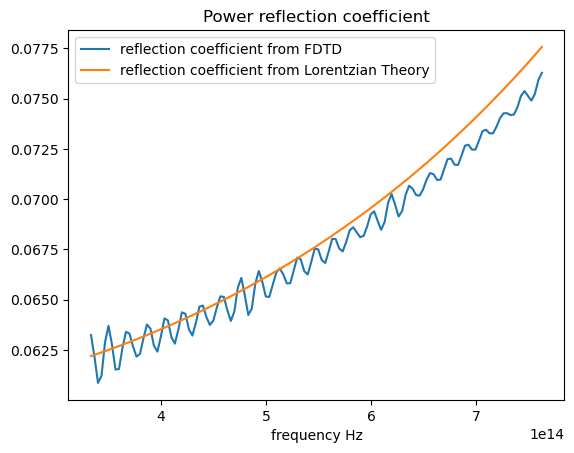

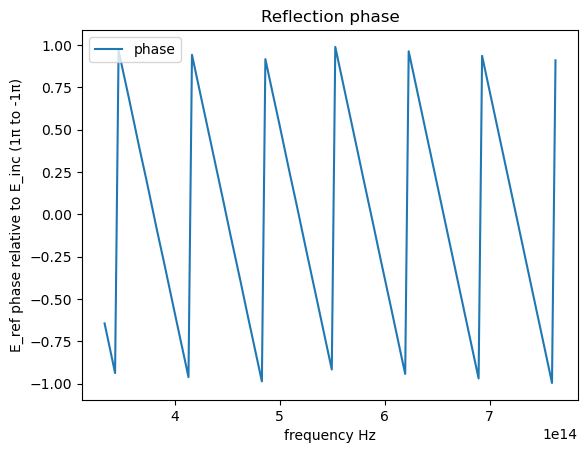

In [13]:
idx1, idx =100, 230
# t_plot = np.abs(Eft[idx1:idx])**2/np.abs(Efi_t[idx1:idx])**2
# t_plot = t_plot/max(t_plot)
# r_plot = np.abs(Efr[idx1:idx])**2/np.abs(Efi_r[idx1:idx])**2
# r_plot = r_plot/max(r_plot)



plt.plot(freqs[idx1:idx],r_plot[idx1:idx],label="reflection coefficient from FDTD")
plt.plot(freqs[idx1:idx],(((n_ref_idx-1)/(n_ref_idx+1))**2)[idx1:idx],label="reflection coefficient from Lorentzian Theory")
plt.title("Power reflection coefficient")
plt.xlabel("frequency Hz")
plt.legend()
plt.show()

plt.plot(freqs[idx1:idx],r_angle_plot[idx1:idx]/np.pi, label="phase")
plt.title("Reflection phase")
plt.ylabel("E_ref phase relative to E_inc (1π to -1π)")
plt.xlabel("frequency Hz")
plt.legend()
plt.show()

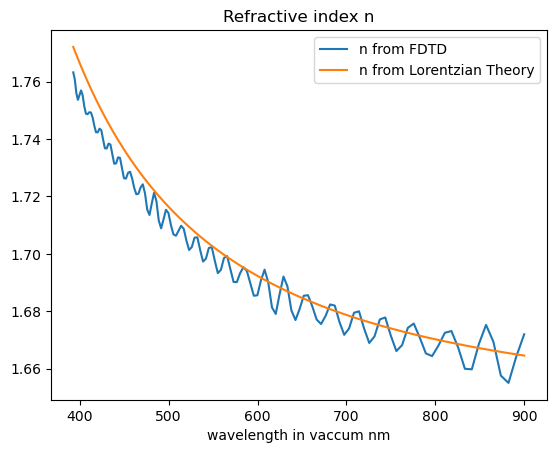

In [14]:
plt.plot(c_0/freqs[idx1:idx]*1e9,(((1+np.sqrt(r_plot))/(1-np.sqrt(r_plot)))[idx1:idx]),label="n from FDTD")
plt.plot(c_0/freqs[idx1:idx]*1e9,n_ref_idx[idx1:idx],label="n from Lorentzian Theory")
plt.title("Refractive index n")
plt.xlabel("wavelength in vaccum nm")
plt.legend()
plt.show()

# Combining everything

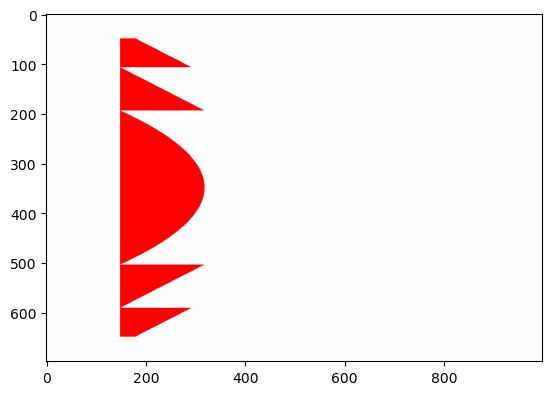

In [15]:
norm = plt.Normalize(-1, 1)
cmap=plt.cm.bwr
plt.imshow(Lor_mask(nx=1000,nz=700,nx_pml=50,nz_pml=30,sample_inc=0)[0].astype(int).T, cmap=cmap,norm=norm)

2D TM FDTD function

In [16]:
import cupy as cp
def Lor_mask(nx,nz,nx_pml,nz_pml,sample_inc):

    if sample_inc:
        nx -=2
        nz -=2
        return cp.zeros((nx,nz)).astype(bool),cp.ones((nx,nz)).astype(bool)

    xs,zs = cp.indices((nx,nz))
    nx_offset = nx_pml + 100- 1/2
    nz_half = (nz/2-1/2)
    xs_norm = xs-(nx_offset)
    zs_norm = zs-(nz_half)

    def _parabola(half_length=1.55,height =1.7):
        half_length *= 100
        height *= 100
        #central parabola

        b1 = (xs_norm<= (-height/half_length**2 *(zs_norm)**2 + height))
        b2 = (xs_norm >= 0)

        return b1 & b2

    def _1stordertri(length=0.87,height =1.7,z_loc=1.55):
        length *= 100
        height *= 100
        z_loc *= 100
        #central parabola

        b1 = (cp.abs(zs_norm) >=z_loc)
        b2 = (xs_norm >= 0)
        b3 = (cp.abs(zs_norm) <= -length/height*(xs_norm)+z_loc+length)

        return b1 & b2 & b3


    def _2ndordertri(angle=0.87/1.7,height =1.44,z_loc=1.55+0.87, z_loc2=3):
        height *= 100
        z_loc *= 100
        z_loc2 *= 100
        #central parabola

        b1 = (cp.abs(zs_norm) >=z_loc)
        b4 = (cp.abs(zs_norm) <=z_loc2)

        b2 = (xs_norm >= 0)
        b3 = (cp.abs(zs_norm) <= -angle*(xs_norm)+z_loc + angle*height)

        return b1 & b2 & b3 & b4
    
    lor_mask = _parabola(half_length=1.55,height =1.7) | \
           _1stordertri(length=0.87,height =1.7,z_loc=1.55) | \
           _2ndordertri(angle=0.87/1.7,height =1.44,z_loc=1.55+0.87, z_loc2=3) 
    not_lor_mask = cp.logical_not(lor_mask)

    is_lor_E = lor_mask[1:-1,1:-1]
    is_notlor_E = not_lor_mask[1:-1,1:-1]
    return is_lor_E,is_notlor_E

def FDTD_2d_lor_pml(f0,sigma_ex_max,sigma_ez_max,sigma_mx_max,sigma_mz_max, steps= 1000, nx=1000,nz=700,nx_pml=50,nz_pml=30,sample_inc=False):

      light_speed =  2.99792458e8        # % speed of light in free space
      n_out = 1.51                        #ref index outside material
      mu_0  = 4.0*np.pi*1.0e-7              # % free space magnetic permeability
      eps_0 = 1.0/((light_speed**2)*mu_0) # % free space dielectric permittivity
      eps_space = n_out**2 *eps_0 # % immersion liquid dielectric permittivity

      # Mesh Definition
      dx = 10e-9
      dz = 10e-9 
      cfl = 0.9
      dt = cfl*dz/(light_speed)/np.sqrt(2) # corresponds to 0.9 of the CFL limit

      # Source excitation function
      Ts = 0.1e-15 # 100 fs, ~30 μm, min pulse duration is ~12 fs, TODO
      # Ts = 1/3.7474e14 #400 nm - 800 nm delta freq
      nmax_exc = round(6*Ts/dt) #  % max number of time steps for excitation, TODO
      # Location of excitation points 

      x_excitation = nx_pml + 80
      hei_excitation = 600
      exc_pts_x = (x_excitation*cp.ones(600)).astype(int)
      exc_pts_z = ((nz - hei_excitation)/2 + cp.arange(hei_excitation)).astype(int)

      sin_excitation = 1
      def _excitation_fx(dt):
            # Spatial gaussian
            dist = exc_pts_z - cp.min(exc_pts_z) - hei_excitation/2 + 1/2
            gauss_spatial = cp.exp(-dist**2/200**2)
            # Modulated Gaussian excitation
            t0 = 3*Ts 
            return cp.sin(2*np.pi*f0*dt)*gauss_spatial
            # return np.exp(-(dt-t0)**2/(2*Ts**2))*np.ones(len(exc_pts_x))
            # return np.exp(-(dt-t0)**2/(2*Ts**2))*np.sin(2*np.pi*f0)*np.ones(len(exc_pt))

      # Multipliers for perfect matched layer
      eps_pml = eps_space
      mu_pml = mu_0
      def _pml_sigma_grad_fx(mu_eps,sig_max,nx,nz):
            xs,zs = cp.indices((nx,nz))

            xs = xs - nx/2 + 1/2
            zs = zs - nz/2 + 1/2

            dist_x = nx/2 - 1/2 - nx_pml
            dist_z = nz/2 - 1/2 - nz_pml

            xs = cp.maximum(abs(xs)-dist_x,0)
            zs = cp.maximum(abs(zs)-dist_z,0)
            xs = xs/(cp.max(xs)-cp.min(xs))
            zs = zs/(cp.max(zs)-cp.min(zs))
            xzs = cp.maximum(xs,zs)

            sig = mu_eps*sig_max*((xzs)**2)
            return sig
      
      pml_sigex = _pml_sigma_grad_fx(eps_pml,sigma_ex_max,nx-2,nz-2)
      pml_sigez  = _pml_sigma_grad_fx(eps_pml,sigma_ez_max,nx-2,nz-2)
      pml_sigmx = _pml_sigma_grad_fx(mu_pml,sigma_mx_max,nx-1,nz)
      pml_sigmz = _pml_sigma_grad_fx(mu_pml,sigma_mz_max,nx,nz-1)

      #Array for fields
      n_store = 20
      n_store_opt = int(cp.round(2/f0/dt))

      Ey = cp.zeros((n_store,nx,nz)) #storage of E field at each time
      Eyx, Eyz = cp.copy(Ey),cp.copy(Ey) #split E field for PML
      Dy = cp.copy(Ey) #storage of D field at each time
      Dyx, Dyz = cp.copy(Ey),cp.copy(Ey) #storage of D field at each time
      Hx = cp.zeros((n_store,nx,nz-1)) #storage of H field at each time
      Bx = cp.copy(Hx) #storage of B field at each time
      Hz = cp.zeros((n_store,nx-1,nz)) #storage of H field at each time
      Bz = cp.copy(Hz) #storage of B field at each time

      Opt_I = cp.zeros((n_store_opt,nx,nz))
      #Mask for Lorentz material
      is_lor_E, is_notlor_E = Lor_mask(nx = nx,nz = nz,nx_pml = nx_pml,
                                       nz_pml = nz_pml,sample_inc=sample_inc)

      #Multipliers for D-E/B-H ADE #INPUT
      omega_p = OMEGA_P
      omega_o = OMEGA_O
      gamma = GAMMA
      
      #general multipliers WITHOUT μ,ε
      _a = (omega_o**2 + omega_p**2)/4 #0th order term multiplier for E/H
      _b = gamma/2/dt #1st order term multiplier for E/H
      _c = 1/dt**2 #2nd order term multiplier for E/H
      _d = (omega_o**2)/4 #0th order term multiplier for D/B
      _e = gamma/2/dt #1st order term multiplier for D/B
      _f = 1/dt**2 #2nd order term multiplier for D/B
      A = _a + _b + _c

      # print(6*Ts/dt)
      tn = 0

      for n in range(steps):
            # print(n)
            n_real = n
            n = n%n_store
            # D-field update

            dt_Dyx = +1/dx*(Hz[n-1,1:,1:-1]-Hz[n-1,:-1,1:-1]) #avoid recomputation.
            dt_Dyz = -1/dz*(Hx[n-1,1:-1,1:]-Hx[n-1,1:-1,:-1]) #avoid recomputation.
            Dyx[n,1:-1,1:-1] = Dyx[n-1,1:-1,1:-1] + dt*dt_Dyx
            Dyz[n,1:-1,1:-1] = Dyz[n-1,1:-1,1:-1] + dt*dt_Dyz
            Dy[n,1:-1,1:-1] = (Dyx[n,1:-1,1:-1] + Dyz[n,1:-1,1:-1]) #update to total field.

            # if np.max(np.abs(Dy[n,1:-1,1:-1][is_lor_E]))/np.max(np.abs(Dy[n-1,1:-1,1:-1][is_lor_E]))>2:
            #       print("Dx:", n_real)

            # E-field update (Free space, PML)
            Eyx[n,1:-1,1:-1][is_notlor_E] = ((eps_pml/dt + pml_sigex/2)**(-1)*(
                              (eps_pml/dt - pml_sigex/2)*Eyx[n-1,1:-1,1:-1] 
                              +1/dx*(Hz[n-1,1:,1:-1]-Hz[n-1,:-1,1:-1]))) [is_notlor_E]

            Eyz[n,1:-1,1:-1][is_notlor_E] = ((eps_pml/dt + pml_sigez/2)**(-1)*(
                              (eps_pml/dt - pml_sigez/2)*Eyz[n-1,1:-1,1:-1] 
                              -1/dz*(Hx[n-1,1:-1,1:]-Hx[n-1,1:-1,:-1])) ) [is_notlor_E]

            Ey[n,1:-1,1:-1][is_notlor_E] = (Eyx[n,1:-1,1:-1] + Eyz[n,1:-1,1:-1])[is_notlor_E] # Update Total E FIELD

            # E- field assign to optical intensity
            if n_real+n_store_opt - 2> steps:
                  Opt_I[n_real%n_store_opt] = Ey[n]

            # E-field update (Lorentizian material)
            g_D1 = _d*(Dyx[n,1:-1,1:-1]+ 2*Dyx[n-1,1:-1,1:-1] + Dyx[n-2,1:-1,1:-1]) + \
                  _e*(Dyx[n,1:-1,1:-1]- Dyx[n-2,1:-1,1:-1]) +\
                  _f*(Dyx[n,1:-1,1:-1]- 2*Dyx[n-1,1:-1,1:-1] + Dyx[n-2,1:-1,1:-1]) 

            f_E1 = eps_0*(_a*(2*Eyx[n-1,1:-1,1:-1] + Eyx[n-2,1:-1,1:-1]) +\
                         _b*(- Eyx[n-2,1:-1,1:-1]) +\
                         _c*(- 2*Eyx[n-1,1:-1,1:-1] + Eyx[n-2,1:-1,1:-1]))
            
            Eyx[n,1:-1,1:-1][is_lor_E] = (1/(eps_0*A) *(g_D1 - f_E1))[is_lor_E]

            g_D2 = _d*(Dyz[n,1:-1,1:-1]+ 2*Dyz[n-1,1:-1,1:-1] + Dyz[n-2,1:-1,1:-1]) + \
                  _e*(Dyz[n,1:-1,1:-1]- Dyz[n-2,1:-1,1:-1]) +\
                  _f*(Dyz[n,1:-1,1:-1]- 2*Dyz[n-1,1:-1,1:-1] + Dyz[n-2,1:-1,1:-1]) 

            f_E2 = eps_0*(_a*(2*Eyz[n-1,1:-1,1:-1] + Eyz[n-2,1:-1,1:-1]) +\
                         _b*(- Eyz[n-2,1:-1,1:-1]) +\
                         _c*(- 2*Eyz[n-1,1:-1,1:-1] + Eyz[n-2,1:-1,1:-1]))
            
            Eyz[n,1:-1,1:-1][is_lor_E] = (1/(eps_0*A) *(g_D2 - f_E2))[is_lor_E]

            Ey[n,1:-1,1:-1][is_lor_E] = Eyz[n,1:-1,1:-1][is_lor_E] + Eyx[n,1:-1,1:-1][is_lor_E]

            # if np.max(np.abs(Ey[n,1:-1,1:-1][is_lor_E]))/np.max(np.abs(Ey[n-1,1:-1,1:-1][is_lor_E]))>2:
            #       print("Ey:", n_real)


            # E-field Excitation
            if sin_excitation or tn<=6*Ts:
                  tn += dt
                  Ey[n,exc_pts_x,exc_pts_z] +=_excitation_fx(tn)
                  
            # B-field update
            dt_Bx = - 1/dz*(Ey[n,:,1:]-Ey[n,:,:-1] ) #avoid recomputation.
            Bx[n] = Bx[n-1] + dt*dt_Bx

            dt_Bz = 1/dx*(Ey[n,1:,]-Ey[n,:-1,:] ) #avoid recomputation.
            Bz[n] = Bz[n-1] + dt*dt_Bz
            
            # if np.max(np.abs(Bz[n,1:,1:-1][is_lor_E]))/np.max(np.abs(Bz[n-1,1:,1:-1][is_lor_E]))>2:
            #       print("Bz:", n_real)
            # H FIELD UPDATE (Normal + PML)
            
            Hx[n] = (mu_pml/dt + pml_sigmz/2)**(-1)*( 
                        (mu_pml/dt - pml_sigmz/2)*Hx[n-1]
                          + dt_Bx)
            # if np.max(np.abs(Hz[n,1:,1:-1][is_lor_E]))/np.max(np.abs(Hz[n-1,1:,1:-1][is_lor_E]))>2:
            #       print("Hz:", n_real)
            
            Hz[n] = (mu_pml/dt + pml_sigmx/2)**(-1)*( 
                        (mu_pml/dt - pml_sigmx/2)*Hz[n-1]
                          + dt_Bz)

      #move GPU arrays to CPU
      Opt_I, Ey, Dy, Hx, Bx, Hz, Bz = Opt_I.get(), Ey.get(), Dy.get(), Hx.get(), Bx.get(), Hz.get(), Bz.get()

      return Opt_I,Ey, Dy, Hx, Bx, Hz, Bz, dt, dx, dz

Running it for three distinct frequencies

In [17]:
Opt_I, Ey, Dy, Hx, Bx, Hz, Bz, dt, dx, dz = FDTD_2d_lor_pml(f0=299792458/(660e-9),
                                                     sigma_ex_max=10e17,sigma_ez_max=10e17,
                                                     sigma_mx_max=10e17,sigma_mz_max=10e17,
                                                      steps= 2500, 
                                                      nx=1000,nz=700,nx_pml=50,nz_pml=30,
                                                      sample_inc=0)

In [18]:
Opt_I2, Ey, Dy, Hx, Bx, Hz, Bz, dt, dx, dz = FDTD_2d_lor_pml(f0=299792458/(800e-9),
                                                     sigma_ex_max=10e17,sigma_ez_max=10e17,
                                                     sigma_mx_max=10e17,sigma_mz_max=10e17,
                                                      steps= 2500, 
                                                      nx=1000,nz=700,nx_pml=50,nz_pml=30,
                                                      sample_inc=0)

# 

In [19]:
Opt_I3, Ey, Dy, Hx, Bx, Hz, Bz, dt, dx, dz = FDTD_2d_lor_pml(f0=299792458/(500e-9),
                                                     sigma_ex_max=10e17,sigma_ez_max=10e17,
                                                     sigma_mx_max=10e17,sigma_mz_max=10e17,
                                                      steps= 2500, 
                                                      nx=1000,nz=700,nx_pml=50,nz_pml=30,
                                                      sample_inc=0)

# Propagation of laser light wavefront

C:\Users\user\AppData\Local\Temp\ipykernel_31500\2808160019.py:1: RuntimeWarning: invalid value encountered in divide
  Opt_I_norm = np.nan_to_num(Opt_I/np.max(np.abs(Opt_I),axis=(1,2)).reshape((-1,1,1)),nan=0)


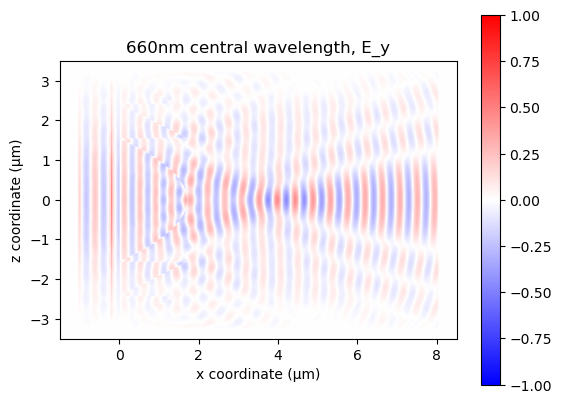

In [20]:
Opt_I_norm = np.nan_to_num(Opt_I/np.max(np.abs(Opt_I),axis=(1,2)).reshape((-1,1,1)),nan=0)

intensity = Opt_I_norm[0]
fig, ax = matplotlib.pyplot.gcf(),matplotlib.pyplot.gca()
cmap = plt.cm.bwr
norm = plt.Normalize(-1, 1)
im = ax.imshow(intensity.T, cmap=cmap,norm=norm, extent=[-1.5,8.5,-3.5,3.5])
fig.colorbar(im,ax=ax)
plt.title("660nm central wavelength, E_y")
plt.xlabel("x coordinate (μm)")
plt.ylabel("z coordinate (μm)")
plt.show()

# Focal length, spot size, chromatic aberration

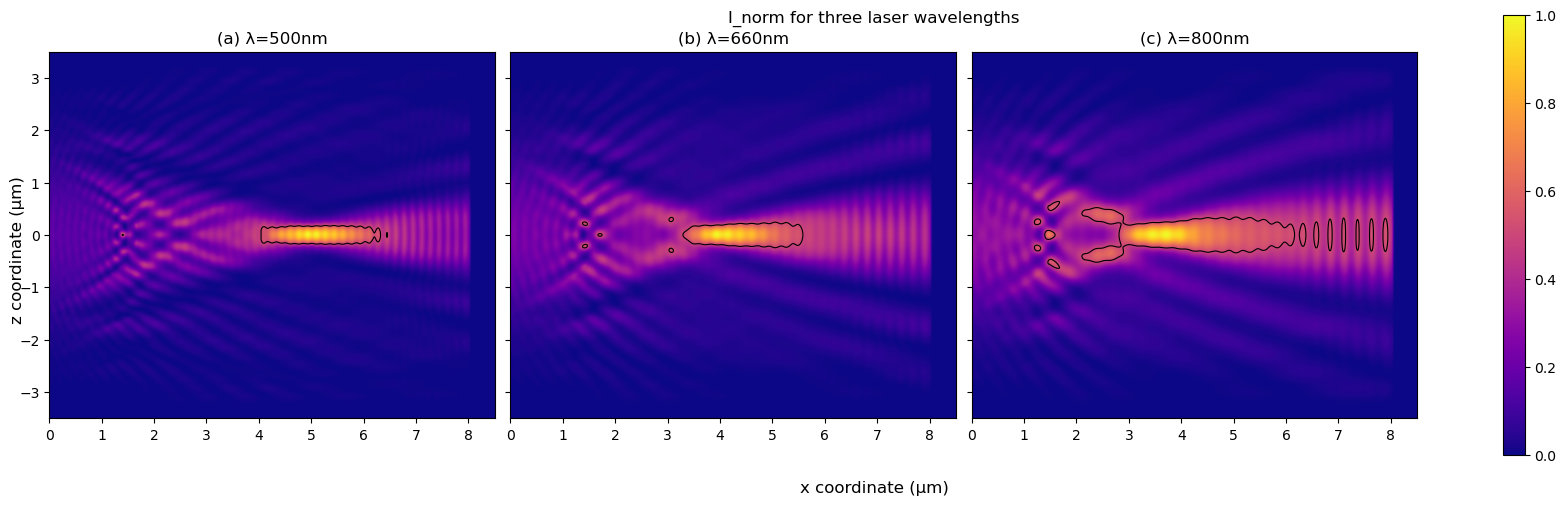

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

idx_start = 150

freq1 = (299792458/500e-9)

fft_freq = fft.rfftfreq(Opt_I3.shape[0],d=dt)
E_final = fft.rfft(Opt_I3[:,idx_start:],axis=0)
idx = np.abs(fft_freq - freq1).argmin()

norm = plt.Normalize(0, 1)
cmap=plt.cm.plasma

intensity1 = (np.abs(E_final[idx])**2/np.max(np.abs(E_final[idx])**2)).T
im = axs[0].imshow(intensity1,cmap=cmap,norm=norm, extent=[0,8.5,-3.5,3.5])
axs[0].contour(intensity1,colors='black',linewidths=0.8,
                        levels=[0.5],linestyles=['solid'], extent=[0,8.5,-3.5,3.5])
axs[0].set_title("(a) λ=500nm")

freq2 = (299792458/660e-9)

fft_freq = fft.rfftfreq(Opt_I.shape[0],d=dt)
E_final = fft.rfft(Opt_I[:,idx_start:],axis=0)
idx = np.abs(fft_freq - freq2).argmin()

intensity = (np.abs(E_final[idx])**2/np.max(np.abs(E_final[idx])**2)).T
im = axs[1].imshow(intensity,cmap=cmap,norm=norm, extent=[0,8.5,-3.5,3.5])
axs[1].contour(intensity,colors='black',linewidths=0.8,
                        levels=[0.5],linestyles=['solid'], extent=[0,8.5,-3.5,3.5])

axs[1].set_title("(b) λ=660nm")

freq3 = (299792458/(800e-9))

fft_freq = fft.rfftfreq(Opt_I2.shape[0],d=dt)
E_final = fft.rfft(Opt_I2[:,idx_start:],axis=0)
idx = np.abs(fft_freq - freq3).argmin()

intensity = (np.abs(E_final[idx])**2/np.max(np.abs(E_final[idx])**2)).T
im = axs[2].imshow(intensity,cmap=cmap,norm=norm, extent=[0,8.5,-3.5,3.5])
axs[2].contour(intensity,colors='black',linewidths=0.8,
                        levels=[0.5],linestyles=['solid'], extent=[0,8.5,-3.5,3.5])


axs[2].set_title("(c) λ=800nm")
fig.supxlabel('x coordinate (μm)')
fig.supylabel('z coordinate (μm)')
plt.tight_layout()

fig.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle("I_norm for three laser wavelengths")
plt.show()

# Wave optic simulation

In [64]:
def prop_angspec_FFT(u1, L, wavelength, zArray):

    N = u1.shape[0]  # [px] input field array size
    assert N%2 ==0

    dx = L / N;  # [m] pixel size
    if dx >= wavelength*max(zArray)/L:
        mode = 1  #near field, use transfer function
        print("z_max = {},near field, use transfer function".format(max(zArray)))
    elif dx <= wavelength*min(zArray)/L:
        mode = 0  #far field, use impulse function
        #check if far field/near field, comp fourier optics, AP1
        print("z_min = {},far field, use impulse function".format(min(zArray)))
    else:
        mode = 1  #near field, use transfer function

    # Transfer function pre calculation, comp fourier optics
    if mode:
        #near field
        fx = cp.arange(-1/ (2 * dx), 1/ (2 * dx) , step=1/ L)  # [m]sampling frequency coordinates
        coeff_H =cp.fft.ifftshift(2*cp.pi/wavelength * (
                                cp.sqrt(( 1 - ((wavelength * fx)**2)))))
    else:
        #far field
        x = cp.arange(-L/2,L/2,step=dx) # [m]sampling space coordinates
        x2 = cp.fft.ifftshift(x**2)

    U1 = cp.fft.fft(cp.fft.ifftshift(u1),norm="ortho") # Shift and take a FT of the source field
    
    u2_tot = np.zeros((len(zArray),N)).astype(np.complex128)
    for c,z in enumerate(zArray):
        if mode:
            #near field
            H = cp.exp( 1j * ((z * coeff_H )))
        else:
            #far field
            k = 2*np.pi/wavelength
            z_2 = z**2
            r_2 = z_2+x2
            r = cp.sqrt(z_2+x2)
            h = -1j*z/wavelength*(cp.exp(1j*k*r)/r_2)
            H = cp.fft.fft(h,norm="ortho")

        H[cp.isnan(H)] = 0 #evanescent field
        #Follow official doc! https://pytorch.org/docs/stable/generated/torch.fft.fftshift.html?highlight=fftshift#torch.fft.fftshift
        U2 = H * U1
        u2 = cp.fft.fftshift( cp.fft.ifft(U2,norm="ortho")) # Take an IFT and center the observed field

        u2_tot[c] = u2.get()

        del H, U2, u2

    del U1

    return u2_tot

In [47]:
def ParaPhase(f, rhoArray,k):

    phase = -(( 1 / (2 * f) * (rhoArray)**2 * k))

    return phase

In [48]:
f_len = 3.8e-6
wavelength = 660e-9/1.51
beamRadius = 2e-6
k = 2*cp.pi/wavelength
nz = 600
zs = (cp.arange(600)-300+1/2)*1e-8
zArray = cp.arange(700)*1e-8

u1_phase = ParaPhase(f_len, zs,k) #lens phase
u1_amp = cp.exp( -zs**2 / beamRadius**2)
u1 = (u1_amp * cp.exp( 1j * u1_phase))

In [78]:
u2s = prop_angspec_FFT(u1, 1e-8*nz, wavelength, zArray)

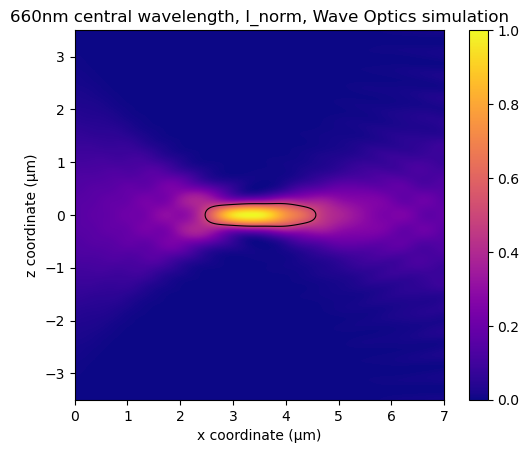

In [80]:
u2s_abs = np.abs(u2s)
cmap = plt.cm.plasma
norm = plt.Normalize(0, 1)
fig, ax = matplotlib.pyplot.gcf(),matplotlib.pyplot.gca()
im = ax.imshow((u2s_abs**2/np.max(u2s_abs**2)).T, cmap=cmap,norm=norm, extent=[0,7,-3.5,3.5])
ax.contour((u2s_abs**2/np.max(u2s_abs**2)).T,colors='black',linewidths=0.8,
                        levels=[0.5],linestyles=['solid'], extent=[0,7,-3.5,3.5])
fig.colorbar(im,ax=ax)
plt.title("660nm central wavelength, I_norm, Wave Optics simulation")
plt.xlabel("x coordinate (μm)")
plt.ylabel("z coordinate (μm)")
plt.show()